# Pre-process EBSD patterns from an Al-Mn alloy

Håkon Wiik Ånes (hakon.w.anes@ntnu.no)

See the relevant package documentation for more details on the packages used here:
* diffsims: https://diffsims.readthedocs.io/en/latest/
* kikuchipy: https://kikuchipy.org/en/stable/
* hyperspy: hyperspy.org/hyperspy-doc/current/
* pyebsdindex: https://pyebsdindex.readthedocs.io/en/latest/
* orix: https://orix.readthedocs.io/en/stable/

Import required packages and print their versions

In [1]:
# Replace "inline" with "qt5" from the pyqt package for interactive plotting
%matplotlib inline

from datetime import date
import importlib_metadata
import os
from time import time

import dask
from diffpy.structure import Lattice, Structure
from diffsims.crystallography import ReciprocalLatticePoint
import hyperspy.api as hs
import kikuchipy as kp
import matplotlib.pyplot as plt
import numpy as np
from pyebsdindex import ebsd_index, pcopt
from orix import io, plot, sampling
from orix.crystal_map import CrystalMap, PhaseList
from orix.quaternion import Rotation


# Directories
dset_no = 1
dir_mp = "/home/hakon/kode/emsoft/emdata/crystal_data"
dir_data = f"/home/hakon/phd/data/p/prover/300c/{dset_no}"
dir_nordif = os.path.join(dir_data, "nordif")
dir_kp = os.path.join(dir_data, "kp")

# Data set specific parameters
cal_pats_al = {1: [10, 11, 12, 13, 14], 2: [0, 6, 7, 8, 9, 10, 11], 3: [9, 10, 11, 12, 13]}
pc0 = {1: (0.48, 0.82, 0.54), 2: (0.46, 0.85, 0.54), 3: (0.50, 0.77, 0.55)}

# Matplotlib
plt.rcParams.update({"figure.figsize": (5, 5), "font.size": 12})
savefig_kw = dict(bbox_inches="tight", pad_inches=0, dpi=150)

print("Run date: ", date.today())
print("\nSoftware versions\n------------------")
for pkg in [
    "dask",
    "diffpy.structure",
    "diffsims",
    "hyperspy",
    "kikuchipy",
    "matplotlib",
    "numpy",
    "pyebsdindex",
    "orix",
]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2022-05-11

Software versions
------------------
dask : 2022.3.0
diffpy.structure : 3.0.1
diffsims : 0.4.2
hyperspy : 1.6.5
kikuchipy : 0.5.7
matplotlib : 3.4.3
numpy : 1.21.5
pyebsdindex : 0.1rc1
orix : 0.8.2


# Pre-correction maps

Load data lazily (not into RAM)

In [2]:
s = kp.load(os.path.join(dir_kp, "patterns_dewrap.h5"), lazy=True)
sig_shape = s.axes_manager.signal_shape[::-1]
print(s.axes_manager)

<Axes manager, axes: (919, 919|96, 96)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    919 |      0 |       0 |     0.1 |     um 
               y |    919 |      0 |       0 |     0.1 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
              dx |     96 |        |       0 |       1 |     um 
              dy |     96 |        |       0 |       1 |     um 


Mean intensity map

In [3]:
s_mean = s.mean(axis=s.axes_manager.signal_axes)
s_mean.compute()

[########################################] | 100% Completed | 14.7s


Save unprocessed map and contrast stretched map

In [4]:
# Unprocessed map
map_mean1 = s_mean.data
plt.imsave(os.path.join(dir_kp, "maps_mean.png"), map_mean1, cmap="gray")

# Contrast stretched map
percentiles = np.percentile(map_mean1, q=(1, 99))
map_mean2 = kp.pattern.rescale_intensity(map_mean1, in_range=percentiles)
plt.imsave(os.path.join(dir_kp, "maps_mean_q1_q99.png"), map_mean2, cmap="gray")

Plot the map

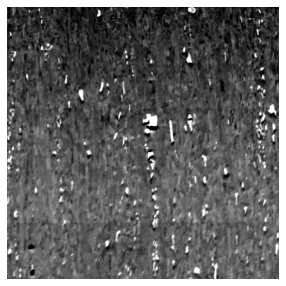

In [5]:
plt.figure()
plt.imshow(map_mean2, cmap="gray")
plt.axis("off");

Generate an RGB virtual backscatter electron (VBSE) image. First, set up the generator

In [6]:
vbse_gen = kp.generators.VirtualBSEGenerator(s)

Plot all grid tiles and hightlight the RGB tiles

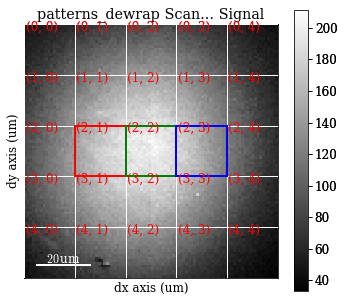

In [7]:
vbse_gen.grid_shape = (5, 5)
red = (2, 1)
green = (2, 2)
blue = (2, 3)
vbse_grid_plot = vbse_gen.plot_grid(
    rgb_channels=[red, green, blue], pattern_idx=(0, 0)
)
vbse_grid_plot._plot.signal_plot.figure.savefig(
    os.path.join(dir_kp, "vbse5x5_grid_plot.png"), **savefig_kw
)

Generate the VBSE RGB image

In [8]:
vbse_rgb = vbse_gen.get_rgb_image(r=red, g=green, b=blue)
vbse_rgb.save(os.path.join(dir_kp, "vbse5x5_rgb.png"))

2022-05-11 16:35:54,516 - hyperspy.io - WARNING - `signal_type='VirtualBSEImage'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals.
2022-05-11 16:36:13,596 - hyperspy.io - WARNING - `signal_type='VirtualBSEImage'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals.
2022-05-11 16:36:26,648 - hyperspy.io - WARNING - `signal_type='VirtualBSEImage'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals.


Overwrite '/home/hakon/phd/data/p/prover/300c/1/kp/vbse5x5_rgb.png' (y/n)?
 y


Plot the VBSE RGB image

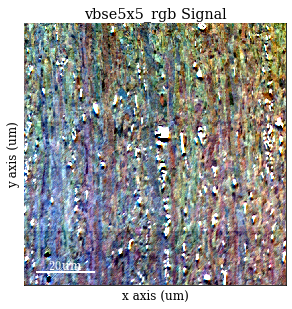

In [9]:
vbse_rgb.plot(navigator=None)

Background correction:
1. Remove static background
2. Remove dynamic background
3. Average patterns with their eight nearest neighbour using a Gaussian kernel with $\sigma$ = 1

In [12]:
s.remove_static_background()

In [13]:
s.remove_dynamic_background()

In [10]:
w = kp.filters.Window(window="gaussian", shape=(3, 3), std=1)

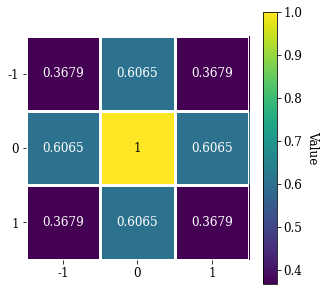

In [11]:
w.plot()

In [14]:
s.average_neighbour_patterns(window=w)

Write processed patterns to file

In [15]:
t0 = time()
s.save(os.path.join(dir_kp, "pattern_sda.h5"))
print((time() - t0) / 60, "min")

11.063304607073466 min


## Pre-indexing maps

Generate image quality $\mathbf{Q}$ and average dot product maps

In [16]:
s = kp.load(os.path.join(dir_kp, "pattern_sda.h5"), lazy=True)
print(s.axes_manager)

<Axes manager, axes: (919, 919|96, 96)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    919 |      0 |       0 |     0.1 |     um 
               y |    919 |      0 |       0 |     0.1 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
              dx |     96 |        |       0 |       1 |     um 
              dy |     96 |        |       0 |       1 |     um 


In [17]:
iq = s.get_image_quality()
adp = s.get_average_neighbour_dot_product_map()

In [18]:
iq2 = iq.compute()

In [21]:
adp2 = adp.compute()

Write maps to file

In [22]:
plt.imsave(os.path.join(dir_kp, "maps_iq.png"), arr=iq2, cmap="gray")
plt.imsave(os.path.join(dir_kp, "maps_adp.png"), arr=adp2, cmap="gray")

Plot maps

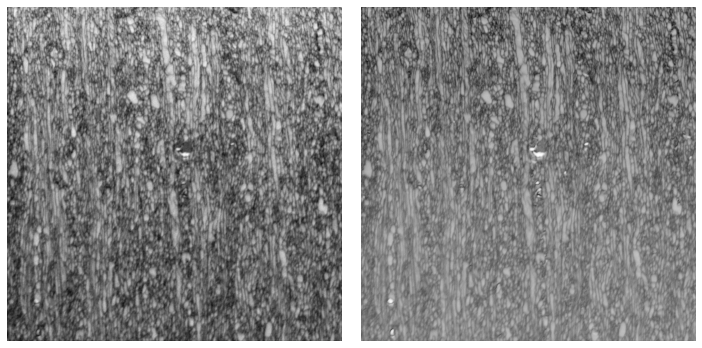

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(iq2, cmap="gray")
ax[1].imshow(adp2, cmap="gray")
ax[0].axis("off")
ax[1].axis("off")
fig.tight_layout()

## Projection center from PyEBSDIndex

Load calibration patterns

In [24]:
s_cal0 = kp.load(os.path.join(dir_nordif, "Setting.txt"))
sig_shape_cal = s_cal0.axes_manager.signal_shape[::-1]

Increase the signal-to-noise ratio

In [25]:
s_cal0.remove_static_background()
s_cal0.remove_dynamic_background()

Removing the static background:
[########################################] | 100% Completed |  0.1s
Removing the dynamic background:
[########################################] | 100% Completed |  0.1s


Plot all patterns

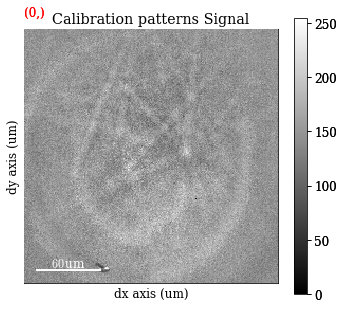

In [26]:
s_cal0.plot(navigator=None)

Extract Al calibration patterns

In [27]:
s_cal = kp.signals.EBSD(s_cal0.data[cal_pats_al[dset_no]])
s_cal.axes_manager[0].name = "x"
nav_size = s_cal.axes_manager.navigation_size

Extract relevant metadata

In [28]:
md_sem = s_cal0.metadata.Acquisition_instrument.SEM
md_ebsd = md_sem.Detector.EBSD
sample_tilt = md_ebsd.sample_tilt  # Degrees
camera_tilt = md_ebsd.azimuth_angle  # Degrees
energy = md_sem.beam_energy  # kV

Generate an indexer instance with PyEBSDIndex for easy storage of relevant
parameters used in projection center (PC) optimization

In [29]:
indexer = ebsd_index.EBSDIndexer(
    phaselist=["FCC"],
    vendor="EDAX",
    PC=None,
    sampleTilt=sample_tilt,
    camElev=camera_tilt,
    patDim=sig_shape_cal[::-1]
)

Find PC from single pattern using an initial guess, as a test

In [30]:
pc0_i = pc0[dset_no]
print(pc0_i)

pc = pcopt.optimize(s_cal.inav[0].data, indexer, PC0=pc0_i)
print(pc)

(0.48, 0.82, 0.54)
[0.47896611 0.81648909 0.546258  ]


Find PC from all patterns

In [31]:
pcs = np.zeros((nav_size, 3))
for i in range(nav_size):
    pcs[i] = pcopt.optimize(s_cal.inav[i].data, indexer, PC0=pc0_i)
print(pcs)

pc = pcs.mean(axis=0)
print(pc)

[[0.47896611 0.81648909 0.546258  ]
 [0.50335333 0.80785247 0.53612236]
 [0.47345909 0.81752695 0.55144123]
 [0.49690248 0.80185017 0.55590791]
 [0.49494569 0.81234299 0.53980456]]
[0.48952534 0.81121233 0.54590681]


Index calibration patterns to check PCs

In [32]:
data = indexer.index_pats(
    patsin=s_cal.data,
    patstart=0,
    npats=-1,
    clparams=None,
    PC=pc,
)
rot = Rotation(data[0]["quat"][0])

In [33]:
detector = kp.detectors.EBSDDetector(
    shape=sig_shape_cal,
    pc=pc,  # Use average PC to reduce potential for single error upon refinement
    sample_tilt=sample_tilt,
    tilt=camera_tilt,
    convention="edax",
)
detector

EBSDDetector (240, 240), px_size 1 um, binning 1, tilt 0.0, azimuthal 0, pc (0.49, 0.189, 0.546)

Load Al master pattern to use in PC refinement and to extract the Al crystal structure

In [34]:
mp = kp.load(
    os.path.join(dir_mp, "al", "al_mc_mp_20kv.h5"),
    projection="lambert",
    energy=energy,
    hemisphere="north",
)
mp.phase.name = "al"

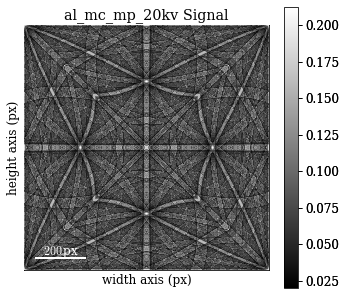

In [39]:
mp.plot(navigator=None)

Inspect geometrical simulations

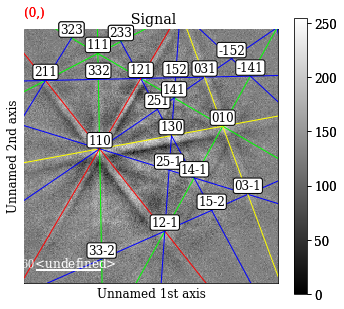

In [35]:
rlp = ReciprocalLatticePoint(phase=mp.phase, hkl=((1, 1, 1), (2, 0, 0), (2, 2, 0), (3, 1, 1)))
rlp2 = rlp.symmetrise()
simgen = kp.generators.EBSDSimulationGenerator(detector=detector, phase=rlp.phase, rotations=rot)
geosim = simgen.geometrical_simulation(reciprocal_lattice_point=rlp2)
markers = geosim.as_markers(pc=False, bands=True, zone_axes_labels=True, zone_axes=False)

#del s_cal.metadata.Markers
s_cal.add_marker(marker=markers, plot_marker=False, permanent=True)
s_cal.plot(navigator=None)

Refine results from PyEBSDIndex

In [36]:
xmap = CrystalMap(rotations=rot, phase_list=PhaseList(mp.phase))

# First refine orientations, then projection centers
ref_kwargs = dict(detector=detector, master_pattern=mp, energy=energy)
xmap_refined = s_cal.refine_orientation(xmap=xmap, **ref_kwargs)
_, detector_ref = s_cal.refine_projection_center(xmap=xmap_refined, **ref_kwargs)

Refinement information:
	Local optimization method: Nelder-Mead (minimize)
	Keyword arguments passed to method: {'method': 'Nelder-Mead'}
Refining 5 orientation(s):
[########################################] | 100% Completed |  3.4s
Refinement speed: 1 patterns/s
Refinement information:
	Local optimization method: Nelder-Mead (minimize)
	Keyword arguments passed to method: {'method': 'Nelder-Mead'}
Refining 5 projection center(s):
[########################################] | 100% Completed |  1.9s
Refinement speed: 2 patterns/s


Check geometrical simulations of refined orientations and PCs

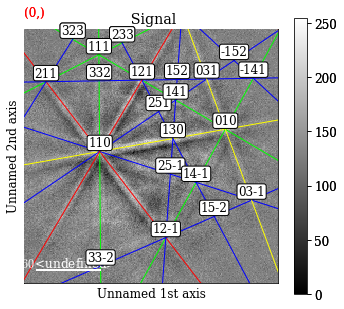

In [37]:
simgen = kp.generators.EBSDSimulationGenerator(
    detector=detector_ref, phase=mp.phase, rotations=xmap_refined.rotations,
)
geosim = simgen.geometrical_simulation(reciprocal_lattice_point=rlp2)
markers = geosim.as_markers(pc=False, bands=True, zone_axes_labels=True, zone_axes=False)

del s_cal.metadata.Markers
s_cal.add_marker(marker=markers, plot_marker=False, permanent=True)
s_cal.plot(navigator=None)

In [38]:
np.savetxt(
    os.path.join(dir_kp, "cal_pcs.txt"),
    np.column_stack((cal_pats_al[dset_no], detector_ref.pc)),
    fmt="%i %.12f %.12f %.12f",
    header="Cal. pattern, PC (x, y, z) in Bruker's convention"
)

## Dictionary indexing

Done in a separate notebook using the above obtained PC.

## Refinement

Done in a separate notebook using the DI results.